In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from prob_rob.motion_models import OdometryMotionModel
from prob_rob.data import read_simple_world, read_simple_data
from prob_rob.utils import normalize_angle, sample_normal_distribution
from prob_rob.robot import BaseRobot
from prob_rob.map import LandmarkMap

In [3]:
class ParticleFilterMotionOnly:
    '''
        One particle contains pose information only
    '''
    def __init__(self, init_pose, motion_model=None, samples=500):
        self.samples = samples
        self.motion_model = motion_model
        self.init_pose = np.copy(init_pose)
        self.particles = []
    
    def step(self, command, noise, sampler):
        
        if len(self.particles) == 0:
            for i in range(0, self.samples):
                m = self.init_pose
                particle = motion_model.sample(m, command, noise, sampler)
                self.particles.append(particle)
            return self.particles
        
        new_particles = []
        for m in self.particles:
            particle = motion_model.sample(m, command, noise, sampler)
            new_particles.append(particle)
            
        self.particles = new_particles[:]
        return self.particles

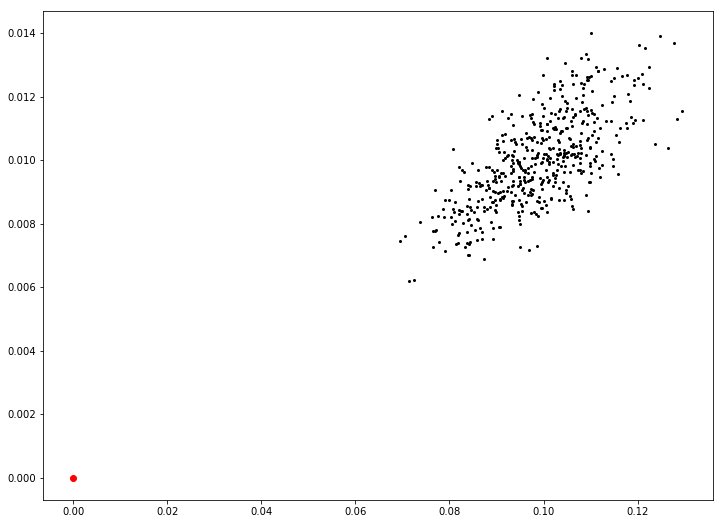

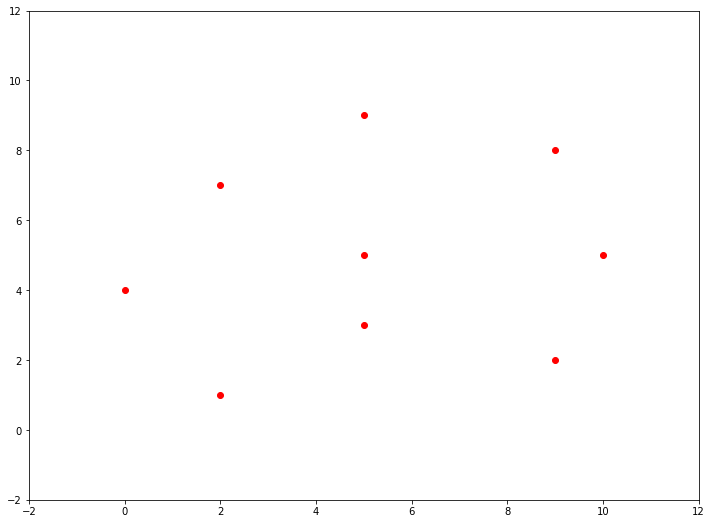

In [4]:
robot = BaseRobot(0, 0, 0)
motion_model = OdometryMotionModel(robot.pose)
robot.motion = motion_model

odometry, sensor = read_simple_data('./data/simple/sensor_data.dat')
landmarks = read_simple_world('./data/simple/world.dat')

landmark_map = LandmarkMap(landmarks)
commands = [np.array(odom).T for odom in odometry]

noise = [0.16, 0.16, 0.16, 0.16]

# Odometry model sampling example
x_sampled = []
y_sampled = []
samples = 500

plt.figure(figsize=(12, 9))
plt.plot(0, 0, 'ro')

pf_sampling = ParticleFilterMotionOnly(robot.pose, robot.motion, samples)
pf_particles = pf_sampling.step(commands[0], noise, sample_normal_distribution)

for sampled_pose in pf_particles:
    x_sampled.append(sampled_pose.item(0))
    y_sampled.append(sampled_pose.item(1))
    
plt.plot(x_sampled, y_sampled, 'ko', markersize=2)

# Plot true robot path and sampled approximations
x = []
y = []
particles_x = []
particles_y = []
particle_filter = ParticleFilterMotionOnly(robot.pose, robot.motion, samples=32)


fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlim((-2, 12))
ax.set_ylim((-2, 12))

ln, = ax.plot([], [], 'bx', markersize=5, zorder=2)
pn, = ax.plot([], [], 'ko', markersize=1, zorder=1)

for key, value in landmark_map.landmarks.items():
    plt.plot(value[0], value[1], 'ro')
    
def init():
    ln.set_data([], []);
    return ln,

def update(frame):
    particles = particle_filter.step(frame, noise, sample_normal_distribution)
    
    for particle in particles:
        particles_x.append(particle.item(0))
        particles_y.append(particle.item(1))
    
    robot.motion_command(frame)
    
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
    ln.set_data(x, y)
    pn.set_data(particles_x, particles_y)
    
    return ln, pn,

ani = FuncAnimation(fig, update, frames=commands, init_func=init, blit=True, interval=100)

In [5]:
HTML(ani.to_html5_video())